##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [204]:
#%pip install pandas 
#%pip install matplotlib
#%pip install pyarrow
#%pip install seaborn
#%pip install sklearn
#%pip install datetime
# %pip install -U imbalanced-learn

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [2]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (GridSearchCV, train_test_split)
from sklearn.ensemble import (GradientBoostingClassifier)
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from imblearn.over_sampling import SMOTE, SMOTENC
from datetime import datetime
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

### 1. Data Exploration

We plot 'annual_income_est', 'hh_size', 'tot_inforce_pols', 'tot_cancel_pols' against the target variable 'f_purchase_lh' as these variables are likely to contribute to the higher conversion rate and retention rate. For example:
1. The higher the annual income, the more likely customers will purchase insurance products within the next 3 months.
2. The higher the household size, the more likely customers will purchase insurance products within the next 3 months as the family likely has more than 2 generations, with more family members exposed to risk such as the elderly and children.
3. The higher total policies in force, the more likely customers will purchase insurance products within the next 3 months, as they seem to be committed to Singlife services.
4. The higher cancelled policies, the less likely customers will purchase insurance products within the next 3 months as they have shown dissatisfaction with Singlife services.
The plots show that there is a trend observed in features 'hh_size', 'tot_inforce_pols', 'tot_cancel_pols', signalling a potential relationship that needs further investigation. Meanwhile, 'annual_income_est' plot does not show significant relationship with 'f_purchase_lh'. However, we do acknowledge that there could be missing or inconsistent data that hampers the data visualisation process. Thus, we proceed with data cleaning and mathematical methods to select appropriate features according to their correlation.

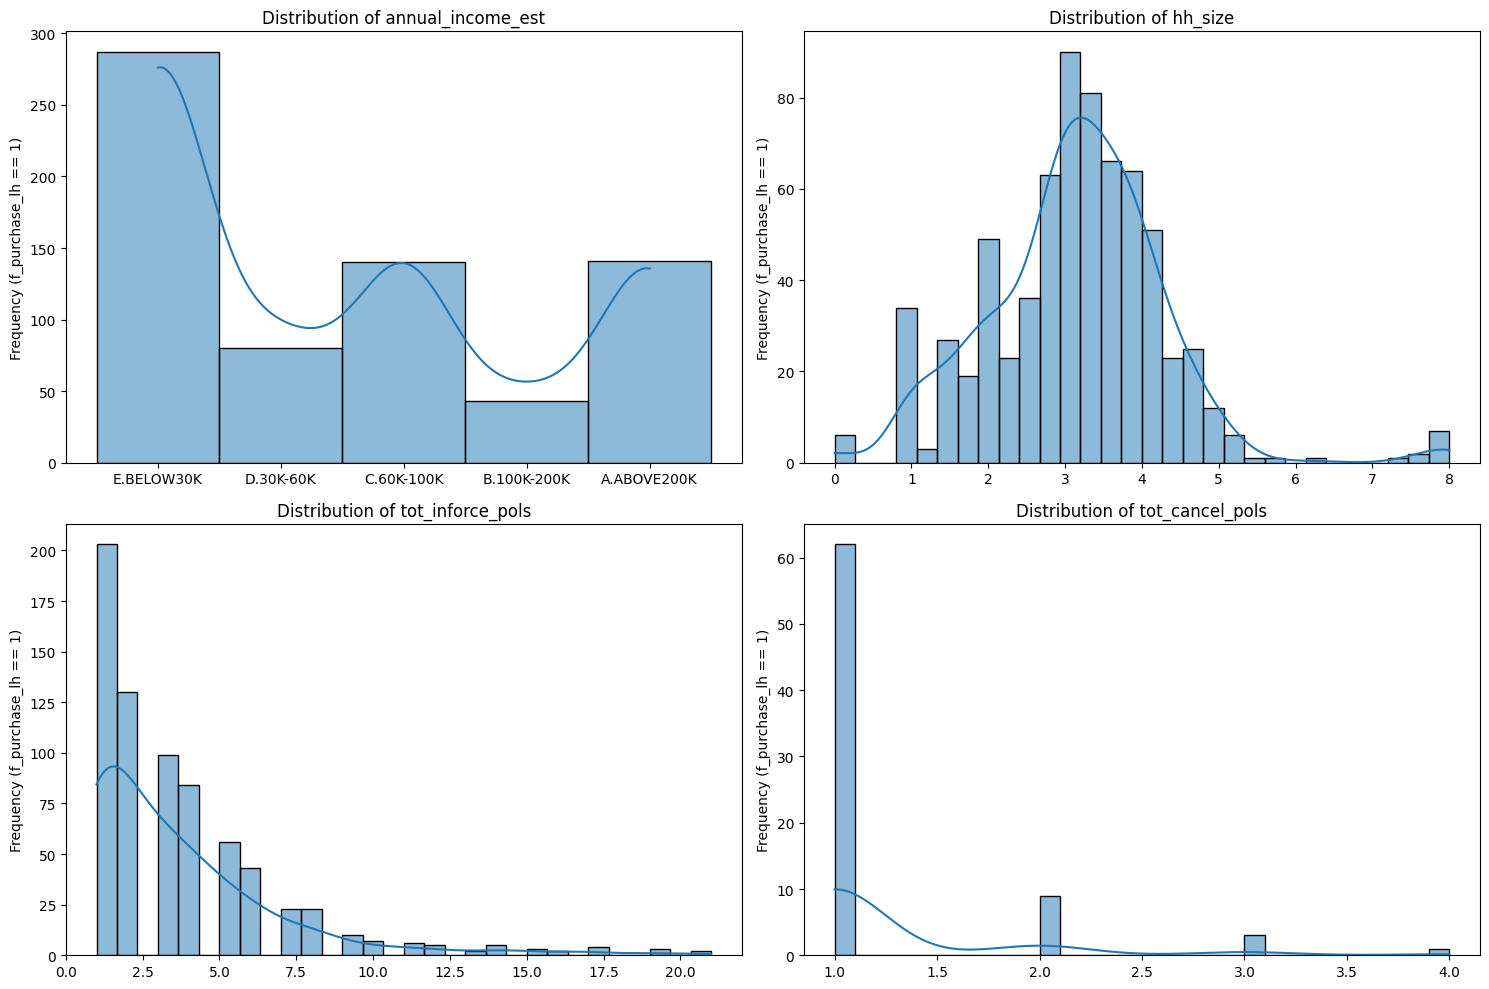

Number of duplicated 'clntnum' values: 0


,% missing
clntnum,0.0
f_hold_gi,0.0
sumins_839f8a,0.0
sumins_e22a6a,0.0
sumins_d0adeb,0.0
...,...
recency_giclaim_unsuccess,100.0
flg_gi_claim_29d435_ever,100.0
flg_gi_claim_058815_ever,100.0
flg_gi_claim_42e115_ever,100.0


In [4]:
filepath = "./data/catB_train.parquet" 
df = pd.read_parquet(filepath)
# print(df.dtypes)

def data_exploration_quadrants(dataframe, target_column, continuous_columns):
    """
    Plot distributions of continuous columns in 4 quadrants based on a filtered DataFrame.

    Parameters:
    - dataframe: DataFrame to filter and plot
    - target_column: Target column for filtering
    - continuous_columns: List of continuous columns to plot
    """
    # Filtering the DataFrame based on the target column
    filtered_df = dataframe[dataframe[target_column] == 1].copy()

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Flatten the axes for easier indexing
    axes = axes.flatten()

    for i, col in enumerate(continuous_columns):
        # Determine the quadrant based on the index
        quadrant = i % 4

        # Sorting categories lexicographically for 'annual_income_est'
        if col == 'annual_income_est':
            sorted_categories = sorted(filtered_df[col].dropna().unique(), reverse=True)
            filtered_df[col] = pd.Categorical(filtered_df[col], categories=sorted_categories, ordered=True)

        # Plotting histograms for continuous columns in the corresponding quadrant
        sns.histplot(filtered_df[col], bins=30, kde=True, ax=axes[quadrant])
        axes[quadrant].set_title(f'Distribution of {col}')
        axes[quadrant].set_xlabel('')
        axes[quadrant].set_ylabel(f'Frequency ({target_column} == 1)')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

continuous_cols = ['annual_income_est', 'hh_size', 'tot_inforce_pols', 'tot_cancel_pols']
data_exploration_quadrants(df, 'f_purchase_lh', continuous_cols)

#flg_latest_being_lapse, flg_latest_being_cancel, tot_inforce_pols do not have missing values
empty_val_check = df[['flg_latest_being_lapse','flg_latest_being_cancel','tot_inforce_pols']]
empty_val_check.isna().sum().sum()

# Check for duplicated rows
duplicated_clntnum_count = df['clntnum'].duplicated(keep=False).sum()
print(f"Number of duplicated 'clntnum' values: {duplicated_clntnum_count}")

# Check for percentages of missing values in each column
missing_vals = df.isna().sum() * 100 / len(df) 
missing_vals.sort_values(inplace=True)

# table of percentages of missing values
missing_vals_df = pd.DataFrame(missing_vals, columns=['% missing'])
missing_vals_df

### 2. Data Cleaning Functions

##### Clean Target Column

In [5]:
def clean_target_column(dataframe, target_column):
    """
    Convert the specified target column to binary (0 or 1), filling missing values with 0.

    Parameters:
    - dataframe: DataFrame to modify
    - target_column: Target column to convert
    """
    dataframe[target_column].fillna(0, inplace=True)
    dataframe[target_column] = dataframe[target_column].astype(int)

    return dataframe

##### Pre-Process Dates and Age

Leveraging existing datetime data after conversion, we create new variables 'length_of_interaction' and 'age' due to their potential impact on the likelihood of customer purchasing insurance products within 3 months. 'length_of_interaction' provides a temporal estimation of their commitment to Singlife to date, and thus likely positively correlates to the retention rate. 'age' is an important factor as customers of older ages are exposed to higher health risks and thus more likely to purchase insurance.

In [6]:
def preprocess_dates_and_age(dataframe):
    """
    Preprocess date columns and calculate length of interaction and age in years.

    Parameters:
    - dataframe: DataFrame to modify
    - min_occ_date_col: Column containing date of interaction
    - cltdob_fix_col: Column containing date of birth

    Returns:
    - Modified DataFrame
    """
    # Convert date columns to datetime
    dataframe['min_occ_date'] = pd.to_datetime(dataframe['min_occ_date'], errors='coerce')
    dataframe['cltdob_fix'] = pd.to_datetime(dataframe['cltdob_fix'], errors='coerce')

    # Calculate length of interaction in days
    dataframe['length_of_interaction'] = (datetime.now() - dataframe['min_occ_date']).dt.days
    dataframe['length_of_interaction'].fillna(dataframe['length_of_interaction'].median(), inplace=True)

    # Calculate age in years
    dataframe['age'] = (datetime.now() - dataframe['cltdob_fix']) / pd.Timedelta(days=365.25)
    dataframe['age'].fillna(dataframe['age'].median(), inplace=True)

    dataframe.drop(columns=['min_occ_date', 'cltdob_fix'], inplace=True)
    
    return dataframe

##### Drop Columns with 100% Missing Values

In [7]:
def drop_column_with_missing_values(dataframe):
    """
    Drop columns with 100% missing values.

    Parameters:
    - dataframe: DataFrame to modify

    Returns:
    - Modified DataFrame
    """
    # Calculate percentages of missing values in each column
    missing_vals = dataframe.isna().sum() * 100 / len(dataframe) 
    missing_vals = missing_vals[missing_vals > 0]
    dataframe.drop(missing_vals[missing_vals == 100].index, axis=1, inplace=True)

    return dataframe

#### A. General Client Information

In [8]:
def impute_client_info(dataframe):
    """
    Impute missing values for client information.

    Parameters:
    - dataframe: DataFrame to impute

    Returns:
    - DataFrame with imputed values
    """
    clnt_info_columns = ['race_desc', 'ctrycode_desc', 'cltsex_fix', 'clntnum', 'clttype', 'stat_flag']

    for clnt_info_column in clnt_info_columns:
        dataframe[clnt_info_column] = dataframe[clnt_info_column].fillna(dataframe[clnt_info_column].mode()[0])
        dataframe[clnt_info_column] = dataframe[clnt_info_column].astype('category')
    return dataframe

#### B. Client Risk and Status Indicators

In [9]:
def impute_client_risk_status(dataframe):
    """
    Impute missing values for client risk and status indicator columns.

    Parameters:
    - dataframe: DataFrame containing client risk and status indicator columns

    Returns:
    - DataFrame with missing values imputed for specified columns
    """
    # Define client risk and status indicator columns
    clnt_risk_status_columns = [
        'flg_substandard', 'flg_is_borderline_standard', 'flg_is_revised_term',
        'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim',
        'flg_gi_claim', 'flg_is_proposal', 'flg_with_preauthorisation', 'flg_is_returned_mail'
    ]

    # Impute missing values for each column with its mode
    for clnt_risk_status_column in clnt_risk_status_columns:
        dataframe[clnt_risk_status_column] = dataframe[clnt_risk_status_column].fillna(dataframe[clnt_risk_status_column].mode()[0])
        dataframe[clnt_risk_status_column] = dataframe[clnt_risk_status_column].astype('category')

    return dataframe


#### C. Client Consent and Communication Preferences

In [10]:
def impute_client_consent(dataframe):
    """
    Impute missing values for client consent and communication preferences columns.

    Parameters:
    - dataframe: DataFrame containing client consent columns

    Returns:
    - DataFrame with missing values imputed for specified columns
    """
    # Define client consent columns
    clnt_consent_columns = [
        'is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call',
        'is_consent_to_sms', 'is_valid_dm', 'is_valid_email'
    ]

    # Impute missing values for each column with its mode
    for clnt_consent_column in clnt_consent_columns:
        dataframe[clnt_consent_column] = dataframe[clnt_consent_column].fillna(dataframe[clnt_consent_column].mode()[0])
        dataframe[clnt_consent_column] = dataframe[clnt_consent_column].astype('category')

    return dataframe

#### D. Policy and Claim History

In [11]:
def impute_negative_and_recency(dataframe):
    """
    Impute negative values for 'n_months_last_bought_products' and recency-related columns.

    Parameters:
    - dataframe: DataFrame containing relevant columns

    Returns:
    - DataFrame with negative values and missing values imputed for specified columns
    """
    # Impute negative values for 'n_months_last_bought_products'
    median_without_negatives = dataframe['n_months_last_bought_products'][dataframe['n_months_last_bought_products'] >= 0].median()
    dataframe['n_months_last_bought_products'] = dataframe['n_months_last_bought_products'].apply(lambda x: x if x >= 0 else median_without_negatives)

    # Impute 'recency_lapse' with 9999 if 'flg_latest_being_lapse' == 0, otherwise with median
    dataframe.loc[dataframe['flg_latest_being_lapse'] == 0, 'recency_lapse'] = 9999
    dataframe.loc[(dataframe['flg_latest_being_lapse'] == 1) & (dataframe['recency_lapse'].isna()), 'recency_lapse'] = 0

    # Impute 'recency_cancel' with 9999 if 'flg_latest_being_cancel' == 0, otherwise with median
    dataframe.loc[dataframe['flg_latest_being_cancel'] == 0, 'recency_cancel'] = 9999
    dataframe.loc[(dataframe['flg_latest_being_cancel'] == 1) & (dataframe['recency_cancel'].isna()), 'recency_cancel'] = 0

    # Impute missing values of 'tot_cancel_pols'
    dataframe.loc[dataframe['flg_latest_being_cancel'] == 0, 'tot_cancel_pols'] = 0
    dataframe.loc[(dataframe['tot_cancel_pols'].isna()) & (dataframe['flg_latest_being_cancel'] == 1), 'tot_cancel_pols'] = 1

    # Impute missing values of 'f_ever_declined_la'
    dataframe['f_ever_declined_la'].fillna(0, inplace=True)

    return dataframe

#### E. Demographic and Household Information, and Other Flags and Metrics

In [12]:
def impute_demographic_household(dataframe):
    """
    Converting data types, applying mappings, and filling missing values for Demographic and Household Information

    Parameters:
    - dataframe: DataFrame to preprocess

    Returns:
    - Preprocessed DataFrame
    """
    # Convert the data type of 'hh_size_est' to the correct data type
    dataframe['hh_size_est'].replace('>4', 5, inplace=True)
    dataframe['hh_size_est'] = pd.to_numeric(dataframe['hh_size_est'], errors='coerce')

    # Mapping for 'annual_income_est' column
    income_mapping = {
        'A.ABOVE200K': 200001,  
        'B.100K-200K': 150000,  
        'C.60K-100K': 80000,
        'D.30K-60K': 45000,
        'E.BELOW30K': 15000
    }
    # Apply the mapping to the 'annual_income_est' column
    dataframe['annual_income_est'].replace(income_mapping, inplace=True)

    # Fill in missing values with the median for specified columns
    col_names_fill_median = ['hh_20', 'pop_20', 'hh_size', 'hh_size_est', 'annual_income_est']
    for c in col_names_fill_median:
        dataframe[c] = pd.to_numeric(dataframe[c], errors='coerce')
        median_value = dataframe[c].median()
        dataframe[c].fillna(median_value, inplace=True)

    # Fill in missing values with the mode for specified columns
    col_names_fill_mode = ['is_housewife_retiree', 'is_sg_pr', 'is_class_1_2', 'is_dependent_in_at_least_1_policy']
    for c in col_names_fill_mode:
        mode_value = dataframe[c].mode()[0]
        dataframe[c].fillna(mode_value, inplace=True)
        dataframe[c] = dataframe[c].astype('category')

    # Fill in missing values with 0 for specified columns
    col_names_fill_zero = ['flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever', 'flg_affconnect_lapse_ever', 'affcon_visit_days', 'clmcon_visit_days']
    for c in col_names_fill_zero:
        dataframe[c].fillna(0, inplace=True)
        dataframe[c] = dataframe[c].astype('category')

    # Fill in missing values with 0 for numeric columns
    for c in dataframe.loc[:, 'hlthclaim_amt':]:
        if c not in dataframe.columns or c =='f_purchase_lh':
            continue
        dataframe[c].fillna(0, inplace=True)
        dataframe[c] = dataframe[c].astype(float)

    # Fill in missing values with 9999 for specified columns
    col_names_fill_9999 = ['n_months_since_visit_affcon', 'recency_clmcon', 'recency_clmcon_regis']
    for c in col_names_fill_9999:
        #if column doesn't exist then continue
        dataframe[c].fillna(9999, inplace=True)
        dataframe[c] = dataframe[c].astype(int)

    dataframe['affcon_visit_days'] = dataframe['affcon_visit_days'].astype(int)
    dataframe['clmcon_visit_days'] = dataframe['clmcon_visit_days'].astype(int)
    return dataframe

#### F. Cleaning Purchase and Lapse Metrics for Specific Products

In [13]:
def fill_missing_lapse_purchase_data(dataframe):
    """
    Fill missing values in lapse and purchase data columns with specified values.

    Parameters:
    - dataframe: DataFrame to fill missing values

    Returns:
    - DataFrame with missing values filled
    """
    # Checking number of empty values in lapse data
    lapse_specific = dataframe.loc[:, 'lapse_ape_ltc_1280bf':'n_months_since_lapse_32c74c']
    lapse_empty_sum = lapse_specific.isna().sum().sum()

    # Fill in missing values with 0 for lapses
    for column in dataframe.loc[:, 'lapse_ape_ltc_1280bf':'lapse_ape_32c74c']:
        dataframe[column] = dataframe[column].fillna(0)

    # Fill in missing values with 9999 for n_months_since_lapse
    for column in dataframe.loc[:, 'n_months_since_lapse_ltc_1280bf':'n_months_since_lapse_32c74c']:
        dataframe[column] = dataframe[column].fillna(9999)

    # Checking number of empty values in purchase data
    purchase_specific = dataframe.loc[:, 'f_ever_bought_839f8a':'n_months_last_bought_32c74c']
    purchase_empty_sum = purchase_specific.isna().sum().sum()

    # Tally number of purchase
    first_set_purchase = dataframe.loc[:, 'f_ever_bought_839f8a':'f_ever_bought_gi']
    sec_set_purchase = dataframe.loc[:, 'f_ever_bought_ltc_1280bf':'f_ever_bought_32c74c']
    combined_purchase_data = pd.concat([first_set_purchase, sec_set_purchase], axis=1)
    dataframe['num_purchase'] = combined_purchase_data.sum(axis=1)

    return dataframe

#### Data Type Conversion

The function fill_missing_lapse_purchase_data serves a crucial role in handling missing values within the lapse and purchase-related columns of our insurance dataset. In the context of insurance data, understanding lapses (instances where policyholders terminate their policies prematurely) and purchase behaviors is essential for predictive modeling and customer insights.

The function first focuses on the lapse-related columns, identifying and addressing missing values within the lapse ages (lapse_ape_...) and the number of months since the last lapse (n_months_since_lapse_...). Recognizing the significance of these columns in understanding policyholder behavior, missing lapse ages are filled with zeros, indicating that no lapses occurred during those periods. Additionally, missing values in the number of months since the last lapse are filled with a high value (9999), effectively marking them as distant time points in the absence of actual lapse information.

Next, the function turns its attention to the purchase-related columns, which include binary indicators of whether a policyholder has ever made specific types of purchases (f_ever_bought_...) and the corresponding number of months since the last purchase (n_months_last_bought_...). To ensure a comprehensive understanding of policyholder engagement, the function tallies the number of purchases across different categories and introduces a new column, num_purchase, summarizing the total number of purchases made by each policyholder. 'num_purchase' feature is created from summing the purchase data of each client. This feature tells us the variety of products customers purchase from Singlife. In comparison to a customer buying one type of product, a customer that purchases more product types likely trusts Singlife service and has higher customer loyalty, which could be used to predict their probability of purchasing insurance products within the next 3 months.

In essence, the function contributes to a holistic preprocessing approach by imputing missing values in critical lapse and purchase-related columns, enabling subsequent analyses and machine learning modeling to capture the nuances of policyholder behavior and engagement with the Singlife insurance products.

In [14]:
def convert_data_to_integer(dataframe):
    columns_to_convert = [col for col in dataframe.columns if col.startswith(('ape_', 'sumins_', 'prempaid_','n_months_last_bought_','n_months_since_lapse_','f_purchase_lh', 'lapse_ape_'))]
    for col in columns_to_convert:
        dataframe[col] = dataframe[col].astype(int)
    return dataframe

In [15]:
def convert_data_to_binary(dataframe):
    columns_to_convert = [col for col in dataframe.columns if col.startswith(('cltsex_fix','flg_','is_','f_ever_bought_','f_', 'race_','clttype','stat_flag'))]
    for col in columns_to_convert:
        dataframe[col] = dataframe[col].astype('category')
    return dataframe

#### One-Hot Encoding

One-hot encoding was employed to handle categorical variables effectively. By transforming categorical variables into a binary matrix, where each category becomes a binary column (0 or 1), this process ensures that the machine learning algorithms can interpret and learn from these categorical variables. The use of one-hot encoding is crucial in preventing the model from assigning unintended ordinal relationships or numerical weights to categorical variables. Without one-hot encoding, the model might incorrectly assume a natural order or hierarchy among the categories, impacting the quality of predictions. Moreover, one-hot encoding expands the feature space, introducing additional columns for each category to allow the algorithm to treat each category as a distinct entity, capturing the diversity within the categorical variables accurately.

In [16]:
def one_hot_encode_categorical(dataframe):
    """
    One-hot encode categorical variables in a DataFrame.

    Parameters:
    - dataframe: DataFrame containing categorical variables

    Returns:
    - DataFrame with one-hot encoded categorical variables
    """
    category_list = ('race_desc','clttype','stat_flag')

    # One-hot encode categorical variables
    for col in category_list:
        dataframe_encoded = pd.get_dummies(dataframe[col], prefix=col)
        dataframe = dataframe.join(dataframe_encoded, lsuffix='_left', rsuffix='_right')

    return dataframe

#### Feature Scaling

Feature scaling was employed to ensure that numerical features with different scales and magnitudes did not unduly influence the performance of our machine learning models. Insurance datasets like Singlife's often contain numerical features that span various ranges, such as annual income, claim amounts, or lengths of interactions. These features may have different units or scales, and their inherent differences could lead to biased model outcomes. For example, a feature with a larger scale might disproportionately impact the model's learning process, overshadowing the contributions of features with smaller scales. By standardizing numerical features using the StandardScaler, we transformed them to have a mean of 0 and a standard deviation of 1. This normalization process ensures that all numerical features contribute uniformly to the model training, preventing any particular feature from dominating the learning process solely due to its scale. Standardizing features also helps algorithms that rely on distance measures, such as Support Vector Machines and K-Nearest Neighbors, to perform more effectively. In essence, feature scaling enhances the model's ability to generalize and make accurate predictions by providing a level playing field for all numerical features, irrespective of their original scales. This preprocessing step contributes to the overall robustness and effectiveness of our machine learning models for Singlife's dataset.

In [17]:
def standardise_numerical_features(dataframe):
    """
    Apply standard scaling to numerical features in a DataFrame.

    Parameters:
    - dataframe: DataFrame containing numerical features

    Returns:
    - DataFrame with standardized numerical features
    """
    scaler = StandardScaler()

    # Identify numerical features
    numerical_features = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Apply standard scaling to numerical features
    dataframe[numerical_features] = scaler.fit_transform(dataframe[numerical_features])

    return dataframe

### Overall Data Cleaning Function

In [18]:
# Overall Data Cleaning Function
def clean_data(dataframe):
    # Pre-Processing
    result = dataframe
    result = preprocess_dates_and_age(result)
    result = fill_missing_lapse_purchase_data(result)
    result = drop_column_with_missing_values(result)

    # Imputing
    result = impute_client_info(result)
    result = impute_client_risk_status(result)
    result = impute_client_consent(result)
    result = impute_negative_and_recency(result)
    result = impute_demographic_household(result)

    if 'f_purchase_lh' in result.columns:
        result = clean_target_column(result, 'f_purchase_lh')
    result = convert_data_to_integer(result)
    result = convert_data_to_binary(result)
    result = one_hot_encode_categorical(result)
    result = standardise_numerical_features(result)

    return result

### 4. Feature Selection

In [19]:
df = clean_data(df)
y = df['f_purchase_lh']

In [223]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
non_numeric_cols = df.select_dtypes(include=["string", "object", "datetime64[ns]"]).columns

### A. Using Point-Biserial Correlation

In insurance datasets, numerical features often represent various customer behaviors or attributes, and understanding their correlation with the purchase likelihood (f_purchase_lh) is crucial for feature selection. That is why we specifically used Point-Biserial Correlation to account for scenarios where one variable is binary, making it a suitable choice for evaluating how continuous features influence the binary outcome of whether a policyholder makes a purchase or not. The calculated correlation coefficients and p-values provide insights into the statistical significance and strength of the relationship between each numerical feature and the purchase likelihood. By sorting the results based on the absolute correlation coefficient in descending order, the code highlights features with the most substantial impact on the binary target variable, thereby aiding in the identification of key predictors for further analysis and modeling.

In [ ]:
# Point-Biserial Correlation
from scipy.stats import pointbiserialr

# Define Features (X) and Target Variable (y)
X = df.drop('f_purchase_lh', axis=1)  # Features
y = df['f_purchase_lh']  # Target variable

# Ensure all arrays have the same length
correlation_coefficients, p_values, feature_names = [], [], []

for column in X.columns:
    if X[column].dtype in ('float', 'int'):  # Exclude non-numerical columns
        correlation_coefficient, p_value = pointbiserialr(X[column], y)
        correlation_coefficients.append(abs(correlation_coefficient))
        p_values.append(p_value)
        feature_names.append(column)

# Combine results into a DataFrame for easier analysis
correlation_df = pd.DataFrame({
    'Feature': feature_names,
    'Correlation Coefficient': correlation_coefficients,
    'P-Value': p_values
})

# Sort by absolute correlation coefficient in descending order
correlation_df = correlation_df.sort_values(by='Correlation Coefficient', ascending=False)

# Display the correlation results
print("Point-Biserial Correlation Results:")
print(correlation_df.head())

Point-Biserial Correlation Results:
                         Feature  Correlation Coefficient        P-Value
176      n_months_last_bought_gi                 0.191234  5.011311e-104
219                 num_purchase                 0.118646   1.025949e-40
6                  recency_lapse                 0.096993   1.037883e-27
203  n_months_since_visit_affcon                 0.081453   5.426553e-20
170  n_months_last_bought_839f8a                 0.080785   1.086700e-19


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5546: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


### B. Using SelectKBest (Mutual Information & Chi-Square)

The SelectKBest method is specifically chosen because it helps identify the most relevant features that contribute significantly to predicting customer satisfaction and understanding the factors influencing customer purchase. The key advantage of SelectKBest lies in its ability to evaluate the statistical strength of each feature in relation to the target variable. In this code, it is used in conjunction with different scoring functions (mutual_info_classif for numeric features and chi2 for categorical features) to assess the information gain or dependency between features and the target variable. By selecting the top k features based on their scores, SelectKBest allows us to focus on a subset of the most influential features, thus reducing dimensionality while preserving the essential information for predictive modeling. SelectKBest thus serves as a valuable tool for pinpointing the most critical variables that drive customer behavior and decision-making.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.drop(columns=['ctrycode_desc', 'cltsex_fix', 'clntnum', 'race_desc','clttype','stat_flag'], inplace=True)

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()

numeric_selector = SelectKBest(score_func=mutual_info_classif, k=5)
categorical_selector = SelectKBest(score_func=chi2, k=5)

X_train_numeric_selected = numeric_selector.fit_transform(X_train[numeric_cols], y_train)
X_train_categorical_selected = categorical_selector.fit_transform(X_train[categorical_cols], y_train)

selected_numeric_indices = numeric_selector.get_support(indices=True)
selected_categorical_indices = categorical_selector.get_support(indices=True)

selected_numeric_features = [numeric_cols[i] for i in selected_numeric_indices]
selected_categorical_features = [categorical_cols[i] for i in selected_categorical_indices]

X_train_selected = pd.concat([pd.DataFrame(X_train_numeric_selected), pd.DataFrame(X_train_categorical_selected)], axis=1)

selected_feature_names = selected_numeric_features + selected_categorical_features
X_train_selected.columns = selected_feature_names

print("Selected Numeric Features:")
print(selected_numeric_features)
print("\nSelected Categorical Features:")
print(selected_categorical_features)
print("\nSelected Data:")
print(X_train_selected.head())


Selected Numeric Features:
['n_months_last_bought_products', 'recency_lapse', 'n_months_last_bought_gi', 'n_months_last_bought_grp_70e1dd', 'num_purchase']

Selected Categorical Features:
['flg_gi_claim', 'flg_latest_being_lapse', 'f_ever_bought_gi', 'f_mindef_mha', 'flg_affconnect_ready_to_buy_ever']

Selected Data:
   n_months_last_bought_products  recency_lapse  n_months_last_bought_gi  \
0                          178.0         9999.0                   9999.0   
1                            3.0         9999.0                      3.0   
2                            8.0         9999.0                   9999.0   
3                           10.0         9999.0                   9999.0   
4                            8.0         9999.0                   9999.0   

   n_months_last_bought_grp_70e1dd  num_purchase  flg_gi_claim  \
0                            178.0           3.0           0.0   
1                           9999.0           1.0           1.0   
2                         

### 5. Modelling

In [23]:
count_ones = (df['f_purchase_lh'] == 1).sum()
count_zeros = (df['f_purchase_lh'] == 0).sum()

print("Number of '1's:", count_ones)
print("Number of '0's:", count_zeros)

Number of '1's: 710
Number of '0's: 17282


### Data Balancing Using Synthethic Minority Oversampling Technique

Given that the number of positive instances of someone purchasing life insurance is 710 out of 17992 data points i.e. 3.95% of the total number of data points, it suggests that the outcome variable is highly imbalanced which might artificially inflate our model’s accuracy score given that the minority class within the target column is underrepresented.

Hence we have decided to employ the Synthetic Minority Oversampling Technique (SMOTE) to reduce the imbalances in the target column.

In [20]:
def balance_data(dataframe):
    X = dataframe.drop(columns=['f_purchase_lh'])
    y = dataframe['f_purchase_lh'].astype(int)
    X.drop(columns=['race_desc', 'ctrycode_desc', 'cltsex_fix', 'clttype', 'stat_flag', 'clntnum'], inplace=True)
    categorical_columns = X.select_dtypes(include=['category']).columns.to_list()
    # Apply SMOTE
    smote = SMOTENC(random_state=42, categorical_features=categorical_columns)
    X_smote, y_smote = smote.fit_resample(X, y)
    return X_smote, y_smote

In [21]:
features = ['n_months_last_bought_products', 'recency_lapse', 'n_months_last_bought_gi', 'n_months_last_bought_grp_70e1dd', 'num_purchase', 'flg_gi_claim', 'flg_latest_being_lapse', 'f_ever_bought_gi', 'f_mindef_mha', 'flg_affconnect_ready_to_buy_ever']
train, test = train_test_split(df, test_size = 0.2, random_state=1, stratify = df['f_purchase_lh'])

These features are selected based on the results of SelectKBest method and application of domain knowledge.
'n_months_last_bought_products', 'n_months_last_bought_': the recency of customers' interaction with Singlife, customers more likely coming back if they just buy a product than if they have not interacted with us for long
'recency_lapse': if policies have lapsed recently, customers may not come back due to their failure to uphold the commitment with Singlife

'num_purchase': customer investment in a variety of products imply higher commitment

flg_gi_claim: This binary categorical feature indicates whether the customer has made a claim related to general insurance. It provides insights into the customer's interaction with the claims process, highlighting potential risk events.

flg_latest_being_lapse: This binary categorical feature flags whether the most recent insurance policy has experienced lapses. It provides a real-time indication of the status of the latest policy, aiding in the identification of potential lapses.

f_ever_bought_gi: This binary categorical feature signifies whether the customer has ever purchased a general insurance product. It captures a broader perspective on the customer's historical engagement with general insurance offerings.

f_mindef_mha: This categorical feature represents the customer's affiliation with the Ministry of Defence (MinDef) and the Ministry of Home Affairs (MHA). It can serve as a segmentation criterion, offering insights into the unique characteristics of customers associated with these government entities.

flg_affconnect_ready_to_buy_ever: This binary categorical feature indicates whether the customer has ever expressed readiness to buy through the Affinity Connect platform. It provides insights into the customer's proactive engagement and interest in purchasing insurance through a specific channel.

### A. Support Vector Machine


After splitting the dataset into a train and test set, we trained a Support Vector Classifier (SVC) model on the train set and tested its predictive power on the test set. We chose the SVC model as it is versatile enough to handle both linear and non-linear classification tasks and is also effective with the relatively small dataset given. We made sure to tune the hyper-parameters of the model using GridSearchCV which also did k-fold cross validation to ensure that the model's performance was assessed across multiple subsets of the training data, reducing the risk of overfitting. It also helped us identify the optimal combination of hyper parameters for the model.

#### I. Training

We are using GridSearchCV to find the best parameters for our SVC model. After training the model, we are able to obtain the best parameters for our model which is SVC(C=100, gamma=1). We then use these parameters to train our model. Given that it takes quite a long time to find this parameter, we commented the code out.

In [242]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.svm import SVC

# train, test = train_test_split(df, test_size = 0.2, random_state=1, stratify = df['f_purchase_lh'])

# X_smote, y_smote = balance_data(train)

# # Reduced parameter range
# param_grid = {
#     'C': [1, 10, 100],  
#     'gamma': [1, 0.01, 0.001], 
#     'kernel': ['rbf']
# }

# # Using RandomizedSearchCV with a specified number of iterations
# grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)

# # Fitting the model for grid search (consider using a subset of data)
# grid.fit(X_smote[features], y_smote)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.761 total time=   3.2s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.788 total time=   3.3s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.794 total time=   3.5s
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.800 total time=   3.4s
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.800 total time=   3.4s
[CV 1/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.717 total time=   4.0s
[CV 2/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.726 total time=   4.3s
[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.726 total time=   4.2s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.732 total time=   4.1s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.729 total time=   4.1s
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.679 total time=   4.6s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'gamma': [1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=3)

In [243]:
# # print best parameter after tuning 
# print(grid.best_params_) 
  
# # print how our model looks after hyper-parameter tuning 
# print(grid.best_estimator_) 

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=100, gamma=1)


In [22]:
X_smote, y_smote = balance_data(df)

# Train the model
model = SVC(C=100, gamma=1)
model.fit(X_smote[features], y_smote)

SVC(C=100, gamma=1)

#### II. Inference

In [24]:
precited_test = model.predict(test[features])
print(precited_test)

[0 0 0 ... 0 0 0]


#### III. Evaluation

In [25]:
test_accuracy = accuracy_score(test['f_purchase_lh'], precited_test)
print(precited_test)
print("Accuracy: " + str(test_accuracy * 100) + "%")

print(classification_report(test['f_purchase_lh'], precited_test))

[0 0 0 ... 0 0 0]
Accuracy: 88.74687413170325%
              precision    recall  f1-score   support

           0       0.98      0.91      0.94      3457
           1       0.16      0.44      0.24       142

    accuracy                           0.89      3599
   macro avg       0.57      0.67      0.59      3599
weighted avg       0.94      0.89      0.91      3599



### B. Decision Tree Algorithm

#### I. Training

In [26]:
X_smote, y_smote = balance_data(df)

clf = DecisionTreeClassifier(max_depth=2, min_samples_leaf=50, min_samples_split=50)
clf.fit(X_smote[features], y_smote)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=50, min_samples_split=50)

#### II. Inference

In [27]:
precited_test_clf = clf.predict(test[features])
print(precited_test_clf)

[0 0 0 ... 0 0 0]


#### III. Evaluation

In [28]:
test_accuracy = accuracy_score(test['f_purchase_lh'], precited_test_clf)
print(precited_test_clf)
print("Accuracy: " + str(test_accuracy * 100) + "%")

print(classification_report(test['f_purchase_lh'], precited_test_clf))

[0 0 0 ... 0 0 0]
Accuracy: 86.19060850236177%
              precision    recall  f1-score   support

           0       0.98      0.88      0.92      3457
           1       0.15      0.51      0.23       142

    accuracy                           0.86      3599
   macro avg       0.56      0.70      0.58      3599
weighted avg       0.94      0.86      0.90      3599



### C. Conclusion

We chose the SVC model as it is versatile enough to handle both linear and non-linear classification tasks and is also effective with the relatively small dataset given. It likely performed better than Decision Trees as it uses more complex decision boundaries and performs better on the higher dimensional data given as it is less prone to overfitting, decision trees tend to be too complex.

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [29]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    features = ['n_months_last_bought_products', 'recency_lapse', 'n_months_last_bought_gi', 'n_months_last_bought_grp_70e1dd', 'num_purchase', 'flg_gi_claim', 'flg_latest_being_lapse', 'f_ever_bought_gi', 'f_mindef_mha', 'flg_affconnect_ready_to_buy_ever']
    hidden_data = clean_data(hidden_data)
    hidden_data = hidden_data[features]
    result = model.predict(hidden_data)
    return result

##### Cell to check testing_hidden_data function

In [30]:
# This cell should output a list of predictions.
from sklearn.metrics import accuracy_score

test_df = pd.read_parquet(filepath)

y_test = test_df['f_purchase_lh']
y_test.fillna(0, inplace=True)

test_df = test_df.drop(columns=["f_purchase_lh"])
test_predictions_array = testing_hidden_data(test_df)
print(test_predictions_array)

[0 0 0 ... 0 1 0]


In [31]:
test_accuracy = accuracy_score(test_predictions_array, y_test)
print(test_predictions_array)
print("Accuracy: " + str(test_accuracy * 100) + "%")

[0 0 0 ... 0 1 0]
Accuracy: 89.0840373499333%


##### Evaluation of Testing Hidden Data

In [32]:
print(classification_report(y_test, test_predictions_array))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94     17282
         1.0       0.17      0.47      0.26       710

    accuracy                           0.89     17992
   macro avg       0.58      0.69      0.60     17992
weighted avg       0.95      0.89      0.91     17992



### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!